In [116]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
from scipy.linalg import solve_triangular

In [117]:
# constants #

ki = 1.2e-06 * 60 # 1/s
kp = 500 * 60 # L/mol*s
ktc = 6e06 * 60# L/mol*s
ktd = 0.0 * 60# 6e06 # L/mol*s
kfm = 9.1e-02 * 60# L/mol*s
kfp = 0.5 * 60# L/mol*s
kpp = 0.05 * 60 # L/mol*s
f = 1.0
M0 = 8.4 # mol/L
I0 = 0.002 #mol/L

In [118]:
@njit
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / (ktd + ktc))

@njit
def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + (ktd + ktc) * L0 + kfp * mu_1
    
    return num / denm

In [119]:
import numpy as np

def log_scale_integers(n, min_val, max_val):
    """
    Genera `n` valores enteros distribuidos logarítmicamente entre `min_val` y `max_val`, 
    reduciendo la densidad excesiva en valores altos.
    
    Parámetros:
        n (int): Cantidad de valores a generar.
        min_val (int): Valor mínimo.
        max_val (int): Valor máximo.
    
    Retorna:
        np.ndarray: Array de `n` valores enteros distribuidos logarítmicamente.
    """
    log_values = np.geomspace(min_val, max_val, n)  # Usa geomspace para mejor distribución
    int_values = np.unique(np.round(log_values).astype(int))
    
    # Asegurar que sean exactamente `n` valores únicos
    if len(int_values) < n:
        extra_values = np.linspace(min_val, max_val, n - len(int_values), dtype=int)
        int_values = np.unique(np.concatenate((int_values, extra_values)))
    
    return int_values # Asegurar que la longitud sea exactamente `n`

# Ejemplo de uso
n = log_scale_integers(400, 5, 1_000_000)

n = np.append(n, [10000200, 10030000])
n.shape

(400,)

In [120]:
# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])

In [121]:
def a_fraction(n):
    """
    Calcula la matriz de resultados con los índices, pares (p, l) y el valor de `ai`.

    Args:
        n (array-like): Array de valores a procesar.

    Returns:
        numpy.ndarray: Matriz con las columnas [idx, p, l, ai].
    """
    n = np.array(n)  # Asegurarse de que 'n' sea un array de numpy
    results = []  # Lista para almacenar los resultados

    for p in range(len(n)):
        for l in range(p, len(n)):
            nj, nk = n[p], n[l]
            njk = nj + nk
            idx = np.searchsorted(n, njk, side="right") - 1  # Encontrar índice del intervalo
            if idx >= 0 and idx < len(n) - 1:
                if njk == n[idx]:
                    ai = 0.0
                else:
                    ai = (n[idx + 1] - (n[p] + n[l])) / (n[idx + 1] - n[idx])
                results.append((idx, p, l, ai))  # Agregar resultado a la lista

    return np.array(results, dtype=object)  # Convertir la lista en un array NumPy

In [122]:
def b_fraction(a_results):
    # Filtrar las filas donde el primer elemento no sea 0
    filtered_results = a_results[a_results[:, 0] != 0]

    # Crear una copia para aplicar las transformaciones
    b = np.copy(filtered_results)

    # Incrementar el primer elemento en 1 y modificar el cuarto elemento
    b[:, 0] = b[:, 0] + 1 # Incrementar el primer elemento
    b[:, 3] = 1.0 - b[:, 3]  # Restar el cuarto elemento de 1.0

    return b

In [123]:
ai = a_fraction(n)
bi = b_fraction(ai)

In [124]:
ai[201]

array([201, 0, 201, 0.9757281553398058], dtype=object)

In [125]:
n[200]

6425

In [126]:
bi[201]

array([202, 0, 201, 0.024271844660194164], dtype=object)

In [127]:
print(n[202])
print(n[201])
print(n[0], n[201]) 
print(n[0] + n[200])
print(n[388])


6830
6624
5 6624
6430
858166


In [128]:
from collections import defaultdict
import numpy as np

ai_dict = defaultdict(list)
bi_dict = defaultdict(list)

# Agrupar los datos, ignorando filas con el último valor = 0 y asegurando enteros
for row in ai:
    idx = int(row[0])  # Índice principal
    if row[3] != 0:  # Si el último valor NO es 0, lo agregamos
        ai_dict[idx].append([int(row[1]), int(row[2]), row[3]])  # Asegurar enteros en las dos primeras columnas

for row in bi:
    idx = int(row[0])  # Índice principal
    if row[3] != 0:  # Si el último valor NO es 0, lo agregamos
        bi_dict[idx].append([int(row[1]), int(row[2]), row[3]])  # Asegurar enteros en las dos primeras columnas

# Convertimos listas en arrays de NumPy asegurando que las dos primeras columnas sean enteros
for key in ai_dict:
    arr = np.array(ai_dict[key], dtype=object)  # Convertir a dtype=object para modificar por columnas
    arr[:, :2] = arr[:, :2].astype(int)  # Convertir las dos primeras columnas a enteros
    ai_dict[key] = np.array(arr.tolist(), dtype=object)  # Reconvertir a un array sin forzar float

for key in bi_dict:
    arr = np.array(bi_dict[key], dtype=object)
    arr[:, :2] = arr[:, :2].astype(int)
    bi_dict[key] = np.array(arr.tolist(), dtype=object)


In [129]:
# Función principal
def balances_KR(t, y):
    
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Nrd = y[5:405]  # Radicales
    Npd = y[405:805]  # Polímeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + (0.5 * ktc + ktd) * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = 0.0 #kp * M * (L0 + 2 * L1) + ktc * L1**2

    # Ecuaciones para los radicales y polímeros
    dNrdt = np.zeros_like(Nrd)
    dNpdt = np.zeros_like(Npd)

    # Resolver para los radicales con QSSA
    A = np.zeros((len(Npd), len(Npd)))
    b = np.zeros(len(Npd))

    for idx in range(len(Npd)):
        if idx == 0:
            A[idx, idx] = -(kfm * M + (ktd + ktc) * L0 + kfp * mu_1) - kp * M * b_p[idx]
            b[idx] = -(kfm * M * L0 + 2 * f * ki * I + kfp * L0 * n[idx] * Npd[idx])
        else:
            A[idx, idx] = -(kfm * M + (ktd + ktc) * L0 + kfp * mu_1) - kp * M * b_p[idx]
            A[idx, idx-1] = kp * M * b_p[idx-1]
            b[idx] = -(kfp * L0 * n[idx] * Npd[idx])
    
    Nrd = solve_triangular(A, b, lower=True)

    for idx in range(len(Npd)):
        # Obtener los valores desde el diccionario o None si no existen
        ai_idx = ai_dict.get(idx, None)
        bi_idx = bi_dict.get(idx, None)

        # Inicializar sumas
        suma_1 = 0.0
        suma_2 = 0.0

        # Solo calcular si hay datos en ai_idx
        if ai_idx is not None and len(ai_idx) > 0:
            idx_0 = np.array(ai_idx[:, 0], dtype=int)  # Convertir la primera columna a int
            idx_1 = np.array(ai_idx[:, 1], dtype=int)  # Convertir la segunda columna a int
            coef = ai_idx[:, 2]  # La tercera columna sigue siendo flotante

            suma_1 = np.sum(coef * Nrd[idx_0] * Nrd[idx_1])
            

        # Solo calcular si hay datos en bi_idx
        if bi_idx is not None and len(bi_idx) > 0:
            idx_0 = np.array(bi_idx[:, 0], dtype=int)  # Convertir la primera columna a int
            idx_1 = np.array(bi_idx[:, 1], dtype=int)  # Convertir la segunda columna a int
            coef = bi_idx[:, 2]  # La tercera columna sigue siendo flotante

            suma_2 = np.sum(coef * Nrd[idx_0] * Nrd[idx_1])

        # Ecuación diferencial
        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                    + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                    + (ktc / 2) * (suma_1 + suma_2))
        
    print(f"t = {t:.2f} y X = {(M0 - M) / M0:2f}")
    print(f"mu1 = {mu_1:.2f}")

    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNrdt, dNpdt))

In [130]:
y0 = np.zeros(805)
y0[0] = I0
y0[1] = M0

time = [0, 3500]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

In [131]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      #t_eval=t_get,
      method='LSODA',
      #rtol=1e-04,
      #atol=1e-06,
      )

t = 0.00 y X = 0.000000
mu1 = 0.00
t = 0.00 y X = 0.000004
mu1 = 0.00
t = 0.00 y X = 0.000004
mu1 = 0.00
t = 0.01 y X = 0.000008
mu1 = 0.00
t = 0.01 y X = 0.000008
mu1 = 0.00
t = 9.18 y X = 0.007760
mu1 = 0.07
t = 9.18 y X = 0.007760
mu1 = 0.07
t = 18.35 y X = 0.015450
mu1 = 0.13
t = 18.35 y X = 0.015450
mu1 = 0.13
t = 27.52 y X = 0.023078
mu1 = 0.19
t = 27.52 y X = 0.023078
mu1 = 0.19
t = 119.25 y X = 0.096042
mu1 = 0.81
t = 119.25 y X = 0.096050
mu1 = 0.81
t = 210.97 y X = 0.163384
mu1 = 1.37
t = 210.97 y X = 0.163357
mu1 = 1.37
t = 302.69 y X = 0.225473
mu1 = 1.89
t = 302.69 y X = 0.225456
mu1 = 1.89
t = 394.41 y X = 0.282779
mu1 = 2.37
t = 394.41 y X = 0.282764
mu1 = 2.37
t = 325.62 y X = 0.240218
mu1 = 2.02
t = 325.62 y X = 0.240218
mu1 = 2.02
t = 348.55 y X = 0.254685
mu1 = 2.14
t = 348.55 y X = 0.254685
mu1 = 2.14
t = 371.48 y X = 0.268866
mu1 = 2.26
t = 371.48 y X = 0.268866
mu1 = 2.26
t = 394.41 y X = 0.282766
mu1 = 2.37
t = 394.41 y X = 0.282766
mu1 = 2.37
t = 396.98 y X = 0.

In [132]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.437e-03 ...  3.495e+03  3.500e+03]
        y: [[ 2.000e-03  2.000e-03 ...  1.555e-03  1.554e-03]
            [ 8.400e+00  8.400e+00 ...  5.183e-01  5.165e-01]
            ...
            [ 0.000e+00  6.523e-64 ... -2.393e-17 -1.478e-17]
            [ 0.000e+00  8.105e-65 ... -1.804e-14 -1.080e-14]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3286
     njev: 4
      nlu: 4

In [133]:
n[360]

515153

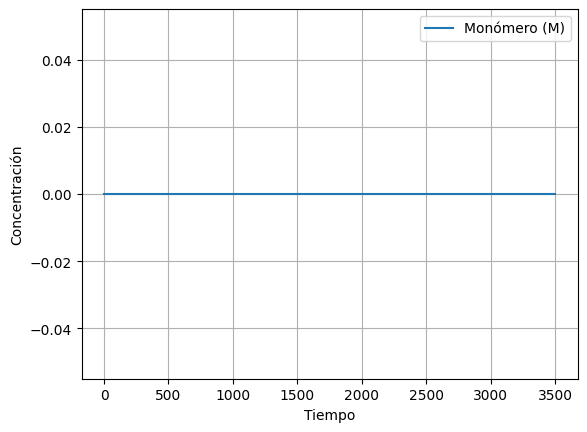

In [134]:
# Visualización
import matplotlib.pyplot as plt


#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[370], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()

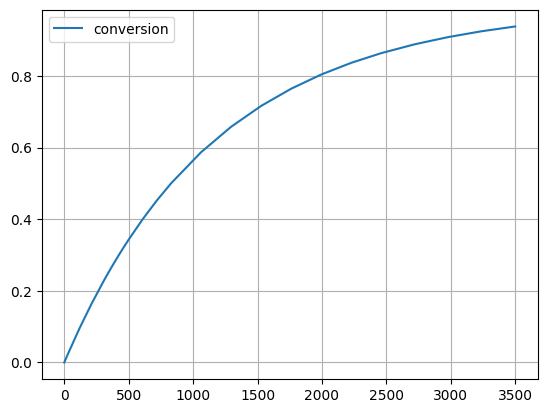

In [135]:
X = (M0 - sol.y[1]) / M0
plt.plot(sol.t, X, label="conversion")
plt.legend()
plt.grid()
plt.show()

In [136]:
sol.t.shape

(40,)

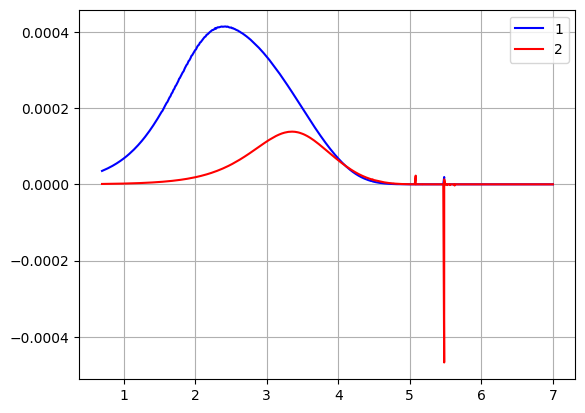

In [140]:
nlog = np.log10(n)
pn1 = sol.y[405:805, 39] / (1/b_p)
pn2 = sol.y[405:805, 12] / (1/b_p)

pn1n = np.multiply(pn1, n)
pn2n = np.multiply(pn2, n)

plt.plot(nlog, pn1n, '-b', label='1')
plt.plot(nlog, pn2n, '-r', label = '2')
plt.grid()
plt.legend()

In [138]:
sol.y[1][34]

1.141115892520664